# **Задание 1 (3 балла)**

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:

добавьте лемматизацию в предобработку (любым способом)
измените размер окна в большую или меньшую сторону
измените размерность итоговых векторов
Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [1]:
# !pip uninstall numpy -y
# !pip install numpy==1.24.4 gensim

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but 

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
import spacy
import re
from string import punctuation
from collections import Counter
from tqdm import tqdm
import spacy.tokens
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.8.0


In [5]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 31.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
class WordIDMapper:
    def __init__(self, corpus):
        self.nlp = spacy.load("ru_core_news_sm", disable=["tagger", "ner"])
        self.nlp.tokenizer = self.tokenize
        vocab, self.lemmatized_sents = self.create_vocab(corpus)
        self.word2id, self.id2word, self.sentences = self.create_indices(
            vocab, self.lemmatized_sents
        )

    def tokenize(self, text):
        tokens = re.sub("#+", " ", text.lower()).split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return spacy.tokens.Doc(self.nlp.vocab, tokens)

    def lemmatize(self, text):
        doc = self.nlp(text)
        lemmata = []
        for sent in doc.sents:
            for token in sent:
                lemmata.append(token.lemma_.lower())
        return lemmata

    def create_vocab(self, corpus):
        unfiltered_vocab = Counter()
        lemmatized_sents = []
        for text in tqdm(corpus, desc="Creating vocab"):
            lemmata = self.lemmatize(text)
            unfiltered_vocab.update(lemmata)
            lemmatized_sents.append(lemmata)
        vocab = set()
        for word in unfiltered_vocab:
            if unfiltered_vocab[word] > 30:
                vocab.add(word)
        return vocab, lemmatized_sents

    def create_indices(self, vocab, sents):
        word2id = {"PAD": 0}
        for word in vocab:
            word2id[word] = len(word2id)
        id2word = {i:word for word, i in word2id.items()}

        sentences = []
        for lemmata in sents:
            if not lemmata:
                continue
            ids = [word2id[lemma] for lemma in lemmata if lemma in word2id]
            sentences.append(ids)

        return word2id, id2word, sentences

In [7]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/wiki_data.txt
wiki = open("wiki_data.txt").read().split("\n")

--2025-06-02 15:26:59--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/wiki_data.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/wiki_data.txt [following]
--2025-06-02 15:27:00--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/wiki_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68582461 (65M) [text/plain]
Saving to: ‘wiki_data.txt.1’

wiki_data.txt.1     100%[===================>]

In [8]:
mapper = WordIDMapper(corpus=wiki)

Creating vocab: 100%|██████████| 20003/20003 [28:50<00:00, 11.56it/s]


In [9]:
vocab_size = len(mapper.id2word)

In [8]:
def most_similar(word, mapper, embeddings):
    similar = [
        mapper.id2word[i] for i in
        cosine_distances(
            embeddings[mapper.word2id[word]].reshape(1, -1),
            embeddings
        ).argsort()[0][:10]
    ]
    return similar

In [9]:
# skip gram
def gen_batches_sg(sentences, window=5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = (sent[max(0, i-left_context_length):i] +
                           sent[i+1:i+right_context_length])
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [10]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))

embeddings_target = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                           output_dim=400)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                            output_dim=400)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation="sigmoid")(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [13]:
model.fit(gen_batches_sg(mapper.sentences[:19000], window=7),
          validation_data=gen_batches_sg(mapper.sentences[19000:], window=7),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=5)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 121s 12ms/step - accuracy: 0.8207 - loss: 0.4024 - val_accuracy: 0.8069 - val_loss: 0.4706
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 121s 12ms/step - accuracy: 0.8232 - loss: 0.4096 - val_accuracy: 0.8244 - val_loss: 0.4045
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 120s 12ms/step - accuracy: 0.8271 - loss: 0.3996 - val_accuracy: 0.8309 - val_loss: 0.3912
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 121s 12ms/step - accuracy: 0.8318 - loss: 0.3902 - val_accuracy: 0.8322 - val_loss: 0.3909
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 120s 12ms/step - accuracy: 0.8340 - loss: 0.3850 - val_accuracy: 0.8370 - val_loss: 0.3809


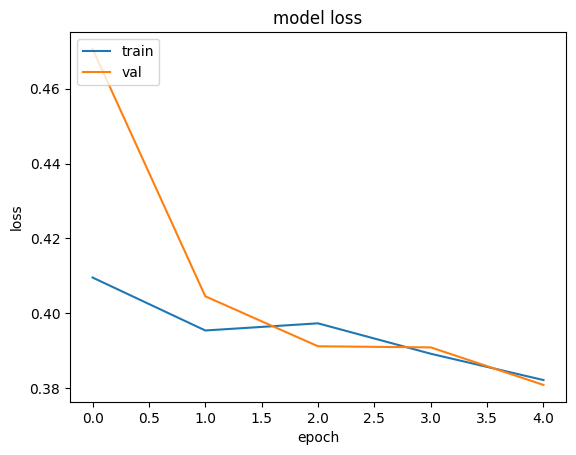

In [14]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [15]:
embedds = model.layers[2].get_weights()[0]
most_similar("мужчина",mapper,embedds)

['мужчина',
 'женщина',
 'спортсмен',
 'домохозяйство',
 'возраст',
 'душа',
 'очко',
 '107',
 '109',
 'трое']

In [16]:
embedds = model.layers[2].get_weights()[0]
most_similar("фашист",mapper, embedds)

['фашист',
 'гитлеровец',
 'партизан',
 'рейх',
 'овандо',
 'сфно',
 'маньчжоу-го',
 'капитуляция',
 'боёв',
 'вооружить']

In [17]:
embedds = model.layers[2].get_weights()[0]
most_similar("программист",mapper, embedds)

['программист',
 'выпускать',
 'маркетинг',
 'электроника',
 'издаваться',
 'филолог',
 'программирование',
 'издатель',
 'графика',
 'magazine']

на тенсорфлоу почему-то не запускался, пришлось переписать модель на пайторч

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
import random


class CBOWNegativeSamplingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.target_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.context_embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target_words, context_words):
        target_emb = self.target_embedding(target_words).squeeze(1)
        context_emb = self.context_embedding(context_words)
        context_emb = context_emb.sum(dim=1)
        dot = (target_emb * context_emb).sum(dim=1)
        return torch.sigmoid(dot)

In [33]:
class CBOWBatchGenerator(IterableDataset):
    def __init__(self, sentences, vocab_size, window=7, batch_size=1000):
        self.sentences = sentences
        self.vocab_size = vocab_size
        self.window = window
        self.batch_size = batch_size

    def __iter__(self):
        left = (self.window + 1) // 2
        right = self.window // 2
        X_target, X_context, y = [], [], []

        for sent in self.sentences:
            for i in range(len(sent)):
                word = sent[i]
                context = sent[max(0, i - left):i] + sent[i+1:i+1 + right]
                if not context:
                    continue
                context += [0] * (self.window - len(context))

                # positive
                X_target.append(word)
                X_context.append(context)
                y.append(1)

                # negative
                X_target.append(random.randint(0, self.vocab_size - 1))
                X_context.append(context)
                y.append(0)

                if len(X_target) >= self.batch_size:
                    yield (
                        torch.tensor(X_target, dtype=torch.long).unsqueeze(1).to(device),
                        torch.tensor(X_context, dtype=torch.long).to(device),
                        torch.tensor(y, dtype=torch.float32).to(device)
                    )
                    X_target, X_context, y = [], [], []

In [35]:
vocab_size = len(mapper.word2id)
sentences = mapper.sentences[:19000]
model = CBOWNegativeSamplingModel(vocab_size, embedding_dim=400).to(device)
dataset = CBOWBatchGenerator(sentences, vocab_size=vocab_size, window=7, batch_size=1000)
dataloader = DataLoader(dataset, batch_size=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(3):
    for i, (target, context, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(target, context)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f"Epoch {epoch}, Step {i}, Loss: {loss.item()}")

Epoch 0, Step 0, Loss: 30.752197265625
Epoch 0, Step 1000, Loss: 24.685365676879883
Epoch 0, Step 2000, Loss: 24.41940689086914
Epoch 0, Step 3000, Loss: 22.397541046142578
Epoch 0, Step 4000, Loss: 21.664703369140625
Epoch 0, Step 5000, Loss: 20.623821258544922
Epoch 0, Step 6000, Loss: 17.938051223754883
Epoch 0, Step 7000, Loss: 19.28921890258789
Epoch 0, Step 8000, Loss: 17.648988723754883
Epoch 1, Step 0, Loss: 16.24729347229004
Epoch 1, Step 1000, Loss: 14.240442276000977
Epoch 1, Step 2000, Loss: 13.814349174499512
Epoch 1, Step 3000, Loss: 16.26650619506836
Epoch 1, Step 4000, Loss: 15.763772010803223
Epoch 1, Step 5000, Loss: 16.84129524230957
Epoch 1, Step 6000, Loss: 14.32714557647705
Epoch 1, Step 7000, Loss: 14.969239234924316
Epoch 1, Step 8000, Loss: 14.961296081542969
Epoch 2, Step 0, Loss: 14.381494522094727
Epoch 2, Step 1000, Loss: 12.176828384399414
Epoch 2, Step 2000, Loss: 13.023837089538574
Epoch 2, Step 3000, Loss: 14.543663024902344
Epoch 2, Step 4000, Loss: 12

In [38]:
embedds = model.target_embedding.weight.detach().cpu().numpy()
most_similar("мужчина", mapper, embedds)

['мужчина',
 'женщина',
 'спортсмен',
 'домохозяйство',
 'возраст',
 'душа',
 'очко',
 '107',
 '109',
 'трое']

In [42]:
most_similar("фашист", mapper, embedds)

['фашист',
 'гитлеровец',
 'партизан',
 'рейх',
 'овандо',
 'сфно',
 'маньчжоу-го',
 'капитуляция',
 'боёв',
 'вооружить']

In [44]:
most_similar("программист", mapper, embedds)

['программист',
 'выпускать',
 'маркетинг',
 'электроника',
 'издаваться',
 'филолог',
 'программирование',
 'издатель',
 'графика',
 'magazine']

Задание 2 (2 балла)
Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [55]:
!pip install gensim

In [1]:
!pip uninstall numpy -y
!pip install --force-reinstall numpy==1.24.4

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but 

In [2]:
import gensim

In [10]:
w2v_model = gensim.models.Word2Vec(
    mapper.lemmatized_sents,
    vector_size=400,
    min_count=35,
    max_vocab_size=12000,
    window=7,
    epochs=10,
    sg=0,
    hs=0,
    negative=7,
    sample=1e-4,
    ns_exponent=0.5,
    cbow_mean=0
)

In [15]:
w2v_model.wv.most_similar('армия')

[('войско', 0.9333748817443848),
 ('дивизия', 0.9112730622291565),
 ('олимпийский', 0.9002574682235718),
 ('завоевать', 0.8998013734817505),
 ('составлять', 0.898353099822998),
 ('население', 0.8981600999832153),
 ('корпус', 0.8965713381767273),
 ('площадь', 0.8960378170013428),
 ('район', 0.8958533406257629),
 ('река', 0.8955796360969543)]

In [19]:
w2v_model.wv.most_similar('наш')

[('мы', 0.8804564476013184),
 ('овладеть', 0.8759976029396057),
 ('будапешт', 0.8621215224266052),
 ('нам', 0.8573886156082153),
 ('индекс', 0.8570533394813538),
 ('финал', 0.8561424612998962),
 ('наконец', 0.8545621037483215),
 ('полуфинал', 0.852914571762085),
 ('телефонный', 0.8526524901390076),
 ('листоед', 0.8522921800613403)]

In [28]:
w2v_model.wv.most_similar('река')

[('приток', 0.9483662843704224),
 ('протекать', 0.9349121451377869),
 ('км²', 0.9312357902526855),
 ('берег', 0.9288055300712585),
 ('впадать', 0.9288044571876526),
 ('озеро', 0.928165853023529),
 ('село', 0.9277862310409546),
 ('олимпийский', 0.9274618625640869),
 ('бассейн', 0.9256325364112854),
 ('завоевать', 0.9250374436378479)]

In [30]:
ft_model = gensim.models.FastText(
    mapper.lemmatized_sents,
    vector_size=400,
    min_count=35,
    max_vocab_size=12000,
    window=7,
    epochs=10,
    sg=0,
    hs=0,
    negative=7,
    sample=1e-4,
    ns_exponent=0.5,
    cbow_mean=0,
    min_n=4,
    max_n=7
)

In [31]:
ft_model.wv.most_similar('мужчина')

[('коростенский', 0.8815025091171265),
 ('романовский', 0.8790214657783508),
 ('женщина', 0.8765239119529724),
 ('мать', 0.8750947713851929),
 ('нина', 0.873283863067627),
 ('нить', 0.8709867000579834),
 ('житомирский', 0.8703004717826843),
 ('юный', 0.869561493396759),
 ('длина', 0.8681715130805969),
 ('поперечный', 0.86790931224823)]

In [32]:
ft_model.wv.most_similar('армия')

[('войско', 0.9173336625099182),
 ('и', 0.8890936374664307),
 ('2001', 0.8887588977813721),
 ('село', 0.8883320093154907),
 ('полк', 0.8883183002471924),
 ('1942', 0.887526273727417),
 ('1941', 0.8850967884063721),
 ('1944', 0.8845878839492798),
 ('1986', 0.8837200999259949),
 ('при', 0.8831079006195068)]

In [33]:
ft_model.wv.most_similar('январь')

[('февраль', 0.9316438436508179),
 ('август', 0.9302026033401489),
 ('ноябрь', 0.9290993809700012),
 ('декабрь', 0.9276484847068787),
 ('апрель', 0.9274832010269165),
 ('март', 0.9257363080978394),
 ('октябрь', 0.9183107018470764),
 ('июль', 0.9123318195343018),
 ('год', 0.905132532119751),
 ('июнь', 0.9029802680015564)]

# ***Задание 3 (3 балла)***
Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор. В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)
F1 мера должна быть выше 20%.

In [34]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/labeled.csv

--2025-06-02 16:10:42--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/labeled.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/labeled.csv [following]
--2025-06-02 16:10:44--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4669913 (4.5M) [application/octet-stream]
Saving to: ‘labeled.csv’

labeled.csv         100%[=================

In [35]:
data = pd.read_csv("labeled.csv")
mapper_for_labeled = WordIDMapper(corpus=data["comment"])

Creating vocab: 100%|██████████| 14412/14412 [02:42<00:00, 88.68it/s]


In [36]:
labels = np.array(data["toxic"])
texts = mapper_for_labeled.lemmatized_sents

embeddings = np.zeros((len(texts), w2v_model.vector_size))
for i, text in enumerate(texts):
    word_embeddings = [
        w2v_model.wv[word] for word in text if word in w2v_model.wv
    ]
    if word_embeddings:
        embeddings[i] = np.mean(word_embeddings, axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.1, random_state=42
)

In [38]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [39]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83       971
         1.0       0.70      0.35      0.47       471

    accuracy                           0.74      1442
   macro avg       0.72      0.64      0.65      1442
weighted avg       0.73      0.74      0.71      1442

